In [1]:
import time
from typing import Any, Sequence, Mapping

In [2]:
# example of fitting a gaussian mixture model with expectation maximization
import numpy as np
from sklearn import mixture
from scipy import stats
from scipy import linalg
from sklearn import model_selection
import pandas as pd
import gymnasium as gym

In [3]:
from rlplg.environments import gridworld, iceworld, redgreen

In [4]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
def mv_normal(mu, eigenvalues):
    dim = len(mu)
    # ortho matrix
    ortho_matrix = stats.ortho_group.rvs(dim)
    # cov matrix; dim x dim
    cov = np.matmul(ortho_matrix, np.matmul(np.diag(eigenvalues), ortho_matrix.T))
    return stats.multivariate_normal(mu, cov)

In [6]:
def high_dim_data(dim: int, num_samples: int):
    mu = [np.random.rand()*np.random.randint(1, 100) for _ in range(dim)]
    eigenvalues = [np.random.rand()*np.random.randint(1, 1000) for _ in range(dim)]
    normal_dist = mv_normal(mu=mu, eigenvalues=eigenvalues)
    return normal_dist.rvs(size=num_samples)

In [7]:
def high_dim_mixture(X, num_components: int):
    # generate a sample
    # fit model
    model = mixture.GaussianMixture(
        n_components=num_components, init_params="k-means++", max_iter=1000
    )
    model.fit(X)
    return model

In [8]:
def solve_least_squares(
    matrix: np.ndarray, rhs: np.ndarray
) -> np.ndarray:
    try:
        solution, _, _, _ = linalg.lstsq(a=matrix, b=rhs, lapack_driver="gelsy")
        return solution  # type: ignore
    except linalg.LinAlgError as err:
        # the computation failed, likely due to the matix being unsuitable (no solution).
        raise ValueError("Failed to solve linear system") from err

In [9]:
def rmse(v_pred: np.ndarray, v_true: np.ndarray, axis: int):
    if np.shape(v_pred) != np.shape(v_true):
        raise ValueError(
            f"Tensors have different shapes: {np.shape(v_pred)} != {np.shape(v_true)}"
        )
    return np.sqrt(
        np.sum(np.power(v_pred - v_true, 2.0), axis=axis) / np.shape(v_pred)[axis]
    )

## Random Data

In [10]:
X = high_dim_data(dim=2, num_samples=100_000)
y = X[:,0]*0.1 + X[:,1]*2 + 0.5

In [11]:
def random_data_rewards(X, y, delay: int, sample_size: int):
    # TODO: test dynamic delay
    mask = np.random.choice(len(X), (sample_size, delay))
    samples = np.sum(X[mask], axis=1) # batch x delay x dim -> batch x dim
    rewards = np.sum(y[mask], axis=1) # batch x delay -> batch
    return samples, rewards

In [12]:
X_delay, y_delay = random_data_rewards(X, y, delay=3, sample_size=10_000)

In [13]:
sol = solve_least_squares(X_delay, y_delay)

In [14]:
sol

array([0.10701163, 2.00247546])

In [15]:
X

array([[ 72.95720281,  25.11286963],
       [ 38.00017067,  70.41511122],
       [ 68.4886213 ,  43.79509747],
       ...,
       [ 57.59996829,  -7.81355847],
       [ 62.80108339,  25.43445719],
       [ 67.35436481, -15.50717309]])

In [16]:
yhat = np.matmul(X, sol)

In [17]:
rmse(v_pred=yhat, v_true=y, axis=0)

0.12924238470099678

In [18]:
y[:10], yhat[:10]

(array([ 58.02145955, 145.13023952,  94.93905706, 126.55566595,
         47.79390878,  90.19857971, -44.66228254,  36.38163445,
         30.00599493,  52.9288503 ]),
 array([ 58.09517406, 145.07099207,  95.02768658, 126.56647441,
         47.50658218,  90.15504346, -44.79232285,  36.38416013,
         30.17861252,  52.82353469]))

## Gym Env

In [19]:
def collection_traj_data(env, steps: int):
    obs, _ = env.reset()
    step = 0
    buffer = []
    while step < steps:
        action = env.action_space.sample()
        next_obs, rew, term, trunc, _,  = env.step(action)
        step += 1
        buffer.append((obs, action, rew))
        obs = next_obs
        if term or trunc:
            obs, _ = env.reset()
    return buffer

In [20]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

In [21]:
def gm_proj(buffer, param_grid):
    obs = np.stack([example[0] for example in buffer])
    grid_search = model_selection.GridSearchCV(
        mixture.GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
    )
    # drop duplicate rows
    return grid_search.fit(obs)

In [22]:
def delay_reward_data(buffer, proj_model, delay: int, sample_size: int):
    obs = np.stack([example[0] for example in buffer])
    action = np.stack([example[1] for example in buffer])
    reward = np.stack([example[2] for example in buffer])
    
    obs_basis = proj_model.predict_proba(obs)
    # repr: (m1,a1)(m2,a1)..
    mdim = obs_basis.shape[1] * len(np.unique(action))
    num_components = obs_basis.shape[1]

    # build samples
    mask = np.random.choice(len(obs_basis), (sample_size, delay))
    delayed_obs = obs_basis[mask] # batch x delay x dim
    delayed_act = action[mask]
    delayed_rew = np.sum(reward[mask], axis=1) # batch x delay -> batch    
    
    rhat_matrix = np.zeros(shape=(len(delayed_obs), mdim))
    
    for i in range(len(delayed_obs)):
        for j in range(delay):
            c = num_components*delayed_act[i][j]
            rhat_matrix[i,c:c+num_components] += delayed_obs[i][j]

    return rhat_matrix, delayed_rew

In [23]:
def proj_obs_to_rwest_vec(buffer, proj_model, sample_size: int):
    obs = np.stack([example[0] for example in buffer])
    action = np.stack([example[1] for example in buffer])
    reward = np.stack([example[2] for example in buffer])
    
    obs_basis = proj_model.predict_proba(obs)
    # repr: (m1,a1)(m2,a1)..
    mdim = obs_basis.shape[1] * len(np.unique(action))
    num_components = obs_basis.shape[1]

    # build samples
    mask = np.random.choice(len(obs_basis), sample_size)
    delayed_obs = obs_basis[mask] # batch x dim
    delayed_act = action[mask] # batch
    delayed_rew = reward[mask] # batch
    
    rhat_matrix = np.zeros(shape=(len(delayed_obs), mdim))
    
    for i in range(len(delayed_obs)):
        c = num_components*delayed_act[i]
        rhat_matrix[i,c:c+num_components] += delayed_obs[i]
    return rhat_matrix, delayed_rew

### Moutain Car

In [24]:
mount_car_buffer = collection_traj_data(env = gym.make("MountainCar-v0"), steps=10_000)

In [25]:
len(mount_car_buffer)

10000

In [26]:
mount_car_buffer[0]

(array([-0.56367916,  0.        ], dtype=float32), 2, -1.0)

In [27]:
mount_car_gmp = gm_proj(mount_car_buffer, param_grid={
    "n_components": range(2, 8),
    "covariance_type": ["spherical", "tied", "diag", "full"],
})

In [28]:
mount_car_gmp

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(2, 8)},
             scoring=<function gmm_bic_score at 0x169e7b560>)

In [29]:
mount_car_gmp.best_estimator_

GaussianMixture(covariance_type='tied', n_components=2)

In [30]:
mount_car_Xd, mount_car_yd = delay_reward_data(mount_car_buffer, mount_car_gmp, delay=10, sample_size=10_000)

In [31]:
mount_car_Xd

array([[1.1437554 , 2.8562446 , 1.83715525, 1.16284475, 1.62787859,
        1.37212141],
       [1.58519114, 2.41480886, 1.11354755, 1.88645245, 0.51811787,
        2.48188213],
       [1.50437233, 2.49562767, 2.15708323, 1.84291677, 1.14801381,
        0.85198619],
       ...,
       [2.47130085, 1.52869915, 2.09042604, 2.90957396, 0.30453032,
        0.69546968],
       [1.27295483, 3.72704517, 1.36053616, 2.63946384, 0.15484995,
        0.84515005],
       [1.10804565, 1.89195435, 1.34931834, 3.65068166, 0.61342823,
        1.38657177]])

In [32]:
mount_car_sol = solve_least_squares(mount_car_Xd, mount_car_yd)

In [33]:
mount_car_sol

array([-1., -1., -1., -1., -1., -1.])

The predicted reward for every state action pair is -1 which is correct.
Though for this problem, it's a constant for every state except the terminal state.

In [34]:
np.matmul(mount_car_Xd, mount_car_sol)

array([-10., -10., -10., ..., -10., -10., -10.])

### Grid World (Different Rewards)

In [35]:
class GW2D(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = gym.spaces.Box(shape=(2,), low=-np.inf, high=np.inf)

    def observation(self, obs):
        # assume one exit
        # Option 1: 3D grid with agent, cliffs, exit (flattened)
        # Option 2: Deltas between agent and cliffs, and exit
        # TODO: experiment with different options
        # This is option 2
        return np.stack(
            [np.array(obs["agent"]) - np.array(obs["exits"][0])]
            + [np.array(obs["agent"]) - np.array(cliff) for cliff in obs["cliffs"]]
        ).flatten()

In [36]:
def solve_gridworld(env_map: str, num_steps: int, sample_size: int, param_grid):
    size, cliffs, exits, start = gridworld.parse_grid_from_text(env_map)
    env = gridworld.GridWorld(size, cliffs, exits, start)
    wrapped_env = GW2D(env)
    buffer = collection_traj_data(wrapped_env, steps=num_steps)
    gmp = gm_proj(buffer, param_grid=param_grid)
    print(gmp.best_estimator_)
    Xd, yd = delay_reward_data(buffer, gmp, delay=2, sample_size=sample_size)
    return wrapped_env, buffer, gmp, solve_least_squares(Xd, yd)

In [37]:
gw_env, gw_buffer, gw_gmp, gw_sol = solve_gridworld(
    "oooooooooooo\noooooooooooo\noooooooooooo\nsxxxxxxxxxxg", num_steps=100_000, sample_size=10_000, param_grid={
        "n_components": range(15, 20),
        "covariance_type": ["spherical", "tied", "diag", "full"],
    }
)

GaussianMixture(covariance_type='tied', n_components=15)


In [38]:
gw_sol

array([ -1.69322311,  -0.77317807,  -0.99921024,  -0.68428026,
        -1.77883767,  -0.90254031,  -1.48534967,  -0.69805338,
        -0.35288665,  -1.04878032,  -1.6956579 ,  -1.49848407,
        -1.69993538,   0.16896464,  -0.08670839,   0.12066277,
        -1.5496084 ,  -1.30515379,  -0.40661769,  -1.52940177,
        -0.92585821,  -0.84890956,  -0.77355343,  -0.10406053,
        -1.34519495,  -0.30907069,  -1.47810872,  -1.17879025,
        -0.21346863,  -0.34639542,  -1.24219201,  -0.52430275,
        -1.3983247 ,  -1.29489406,  -1.23116539,  -1.25648413,
        -1.113972  ,  -0.71453269,  -1.12491707,  -0.56352608,
        -0.70019364,  -0.71525399,  -0.90443451,  -0.85804296,
        -1.11960737,  -1.24760144,  -2.05268212,  -0.59726043,
        -1.09893197,  -1.48301159, -40.21845727,  -0.84802235,
        -1.15262248,  -0.97656205,  -1.4643233 ,   5.85104147,
        -1.31241959,  -0.34655692,  -1.41009422,  -1.13269488])

In [39]:
gw_gmp

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(15, 20)},
             scoring=<function gmm_bic_score at 0x169e7b560>)

In [40]:
gw_eval_X, gw_eval_y = proj_obs_to_rwest_vec(gw_buffer, gw_gmp, sample_size=10_000)

/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this war

<Axes: xlabel='reward', ylabel='Count'>

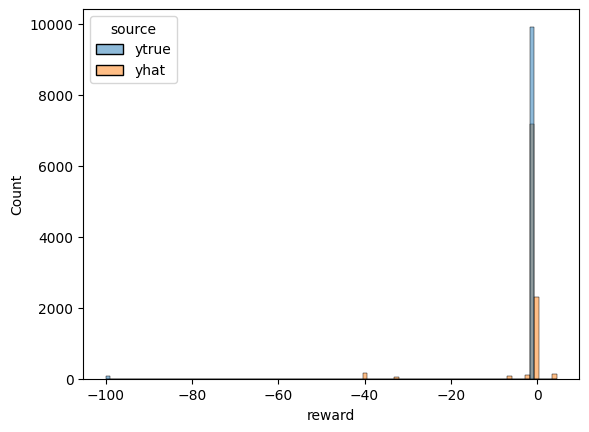

In [41]:
sns.histplot(
    pd.DataFrame({
        "reward": gw_eval_y.tolist() + np.matmul(gw_eval_X, gw_sol).tolist(),
        "source": ["ytrue"]*len(gw_eval_y) + ["yhat"]*len(gw_eval_X)
    }),
    x="reward",
    hue="source",
    bins=100
)

In [42]:
gw_eval_X.shape, gw_eval_y.shape

((10000, 60), (10000,))

In [43]:
rmse(
    v_pred=np.matmul(gw_eval_X, gw_sol), 
    v_true=gw_eval_y,
    axis=0
)

6.871938229010958

In [44]:
np.unique(np.around(np.matmul(gw_eval_X, gw_sol), 2))

array([-4.017e+01, -3.958e+01, -3.278e+01, -6.770e+00, -1.860e+00,
       -1.840e+00, -1.720e+00, -1.680e+00, -1.660e+00, -1.640e+00,
       -1.560e+00, -1.540e+00, -1.520e+00, -1.510e+00, -1.490e+00,
       -1.480e+00, -1.470e+00, -1.460e+00, -1.450e+00, -1.420e+00,
       -1.410e+00, -1.370e+00, -1.360e+00, -1.350e+00, -1.340e+00,
       -1.320e+00, -1.310e+00, -1.290e+00, -1.270e+00, -1.260e+00,
       -1.250e+00, -1.230e+00, -1.220e+00, -1.200e+00, -1.190e+00,
       -1.180e+00, -1.170e+00, -1.160e+00, -1.140e+00, -1.120e+00,
       -1.110e+00, -1.100e+00, -1.070e+00, -1.060e+00, -1.050e+00,
       -1.040e+00, -1.030e+00, -1.020e+00, -1.010e+00, -9.900e-01,
       -9.800e-01, -9.600e-01, -9.400e-01, -9.300e-01, -9.200e-01,
       -9.100e-01, -9.000e-01, -8.900e-01, -8.800e-01, -8.600e-01,
       -8.500e-01, -8.300e-01, -8.200e-01, -8.000e-01, -7.900e-01,
       -7.800e-01, -7.600e-01, -7.500e-01, -7.400e-01, -7.200e-01,
       -7.100e-01, -6.900e-01, -6.800e-01, -6.700e-01, -6.600e

## RedGreen

In [45]:
class RG2D(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = gym.spaces.Box(shape=(2,), low=-np.inf, high=np.inf)

    def observation(self, obs):
        # assume one exit
        # Option 1: 3D grid with agent, cliffs, exit (flattened)
        # Option 2: Deltas between agent and cliffs, and exit
        # TODO: experiment with different options
        # This is option 2
        return np.array([obs["pos"], len(obs["cure_sequence"])])

In [46]:
def solve_redgreen(env_seq: Sequence[str], num_steps: int, sample_size: int, param_grid):
    env = redgreen.RedGreenSeq(env_seq)
    wrapped_env = RG2D(env)
    buffer = collection_traj_data(wrapped_env, steps=num_steps)
    gmp = gm_proj(buffer, param_grid=param_grid)
    print(gmp.best_estimator_)
    Xd, yd = delay_reward_data(buffer, gmp, delay=2, sample_size=sample_size)
    return wrapped_env, buffer, gmp, solve_least_squares(Xd, yd)

In [47]:
rg_env, rg_buffer, rg_gmp, rg_sol = solve_redgreen(
    ["red", "green", "red", "green", "wait", "green"], 
    num_steps=100_000, 
    sample_size=10_000, 
    param_grid={
        "n_components": range(2, 10),
        "covariance_type": ["spherical", "tied", "diag", "full"],
    }
)

/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (6

GaussianMixture(covariance_type='tied', n_components=6)


In [48]:
rg_sol

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1.])

## Lunda Lander

In [49]:
def solve_lunar(num_steps: int, sample_size: int, param_grid):
    env = gym.make("LunarLander-v3")
    wrapped_env = env
    buffer = collection_traj_data(wrapped_env, steps=num_steps)
    gmp = gm_proj(buffer, param_grid=param_grid)
    print(gmp.best_estimator_)
    Xd, yd = delay_reward_data(buffer, gmp, delay=2, sample_size=sample_size)
    return wrapped_env, buffer, gmp, solve_least_squares(Xd, yd)

In [50]:
lunar_env, lunar_buffer, lunar_gmp, lunar_sol = solve_lunar(
    num_steps=100_000,
    sample_size=10_000, 
    param_grid={
        "n_components": range(2, 6),
        "covariance_type": ["spherical", "tied", "diag", "full"],
    }
)

GaussianMixture(n_components=4)


In [51]:
lunar_sol

array([-1.96735394e+00, -3.09925684e+01, -2.58006892e+01, -6.83397723e-01,
       -1.92228142e+00, -3.99332411e+01, -1.45658869e+01, -7.00334170e-01,
        3.52824394e-02, -2.76119058e+01, -2.83719450e+01, -5.34424218e-01,
       -1.80199500e+00, -2.09511277e+01, -2.70988500e+01, -1.08703304e+00])

In [52]:
lunar_eval_X, lunar_eval_y = proj_obs_to_rwest_vec(lunar_buffer, lunar_gmp, sample_size=10_000)

In [53]:
lunar_eval_X.shape, lunar_eval_y.shape

((10000, 16), (10000,))

In [54]:
np.matmul(lunar_eval_X, lunar_sol)

array([ -1.96735394,  -1.72657537, -28.37194502, ...,  -1.96735394,
        -0.53420497,   0.03525956])

In [55]:
lunar_eval_y

array([-0.74021949, -2.34470049, -2.30475461, ..., -1.78850267,
        1.1894368 ,  2.25132635])

/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this war

<Axes: xlabel='reward', ylabel='Count'>

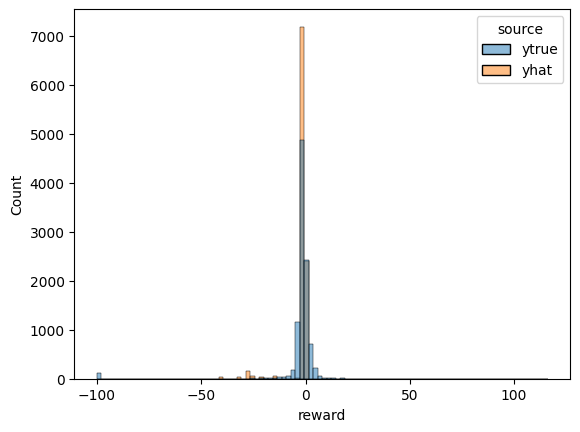

In [56]:
sns.histplot(
    pd.DataFrame({
        "reward": lunar_eval_y.tolist() + np.matmul(lunar_eval_X, lunar_sol).tolist(),
        "source": ["ytrue"]*len(lunar_eval_y) + ["yhat"]*len(lunar_eval_X)
    }),
    x="reward",
    hue="source",
    bins=100
)

In [57]:
rmse(
    v_pred=np.matmul(lunar_eval_X, lunar_sol), 
    v_true=gw_eval_y,
    axis=0
)

10.083902842791133